In [1]:
# importing python libraries
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# Load the datasets into pandas DataFrames
X_train = pd.read_csv("X_train_final.csv")
X_val = pd.read_csv("X_val_final.csv")
X_test = pd.read_csv("X_test_final.csv")

y_train = pd.read_csv("y_train.csv").squeeze()
y_val = pd.read_csv("y_val.csv").squeeze()
y_test = pd.read_csv("y_test.csv").squeeze()

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Logistic regression model

In [3]:
# 1. Train on the training set
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# 2. Evaluate on training and validation sets
y_train_pred = logreg.predict(X_train)
y_val_pred = logreg.predict(X_val)

# 3. Check for underfitting/overfitting
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Training Accuracy: 0.7111
Validation Accuracy: 0.6872


The training accuracy and validation accuracy are fairly close. the model is overfitting.  

### Using hyperparameter tuning on logistic regression model

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import numpy as np
# Combine training and validation sets for tuning
X_tune = pd.concat([X_train, X_val], axis=0)
y_tune = pd.concat([y_train, y_val], axis=0)

# Parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced']
}

# Initialize model
lr = LogisticRegression(max_iter=1000, random_state=42)

# Grid Search
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit model
grid_search.fit(X_tune, y_tune)

# Best model
best_lr = grid_search.best_estimator_

print("Best Parameters:\n", grid_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters:
 {'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


In [5]:
# Predictions
y_test_pred = best_lr.predict(X_test)

# Accuracy
test_acc_lr = accuracy_score(y_test, y_test_pred)
print("Logistic Regression Test Accuracy:", test_acc_lr)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Logistic Regression Test Accuracy: 0.6831275720164609
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        77
           1       0.68      1.00      0.81       166

    accuracy                           0.68       243
   macro avg       0.34      0.50      0.41       243
weighted avg       0.47      0.68      0.55       243



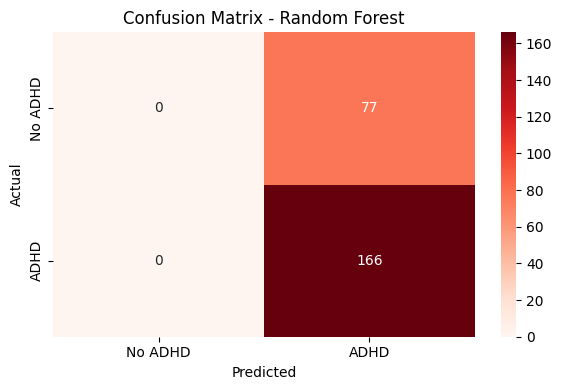

In [11]:
cm_lr=confusion_matrix(y_test, y_test_pred)
class_names = ['No ADHD', 'ADHD']
# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.show()

### Random forest classfier model

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict on validation and test sets
y_val_pred = rf.predict(X_val)
y_train_pred = rf.predict(X_train)
# Evaluate performance
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))

Validation Accuracy: 0.6872427983539094
Training Accuracy: 1.0


The random forest model is overfitted and imbalanced dataset

### Using hyperparameter tuning on Random forest classifier

In [13]:
# Combine training and validation sets
X_tune = pd.concat([X_train, X_val], axis=0)
y_tune = pd.concat([y_train, y_val], axis=0)

# Expanded and adjusted parameter grid
param_dist = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [6, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 0.3],
    'class_weight': ['balanced'],
    'bootstrap': [True]
}
# Defining model
rf = RandomForestClassifier(random_state=42)
# Randomized search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=40,
    cv=5,
    scoring='roc_auc',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fitting to training+validation data
random_search.fit(X_tune, y_tune)

# best model
best_rf = random_search.best_estimator_
print("Best Parameters:\n", random_search.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters:
 {'n_estimators': 700, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 6, 'class_weight': 'balanced', 'bootstrap': True}


In [14]:
# Predict on the test set
y_test_pred_rf = best_rf.predict(X_test)
# Accuracy and classification report
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)
print("Random Forest Test Accuracy:", test_acc_rf)
print("Classification Report:\n", classification_report(y_test, y_test_pred_rf))

Random Forest Test Accuracy: 0.6995884773662552
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.10      0.18        77
           1       0.70      0.98      0.82       166

    accuracy                           0.70       243
   macro avg       0.68      0.54      0.50       243
weighted avg       0.69      0.70      0.61       243



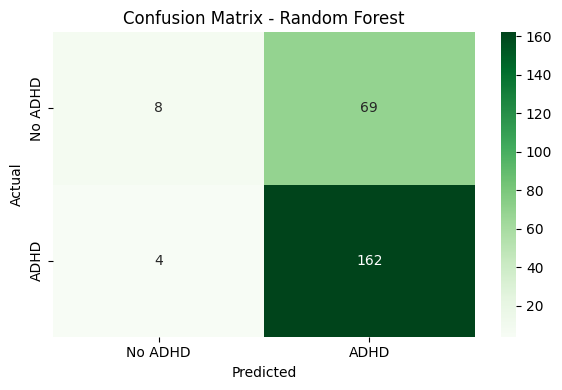

In [15]:
cm = confusion_matrix(y_test, y_test_pred_rf)
# Define class names
class_names = ['No ADHD', 'ADHD']
# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.show()

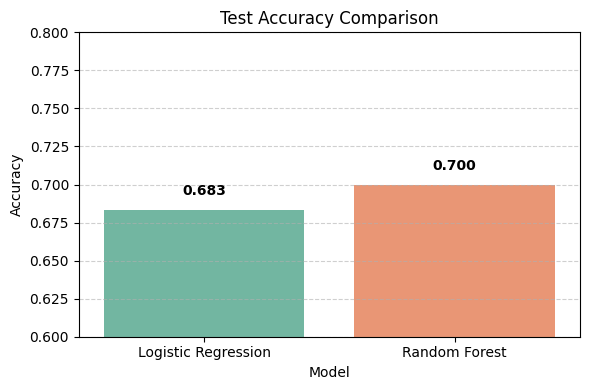

In [16]:
acc_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Test Accuracy': [test_acc_lr, test_acc_rf]
})
# Bar Plot
plt.figure(figsize=(6, 4))
sns.barplot(x='Model', y='Test Accuracy', hue='Model', data=acc_df, palette='Set2')
plt.ylim(0.6, 0.8)
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add accuracy labels on top of bars
for i, v in enumerate(acc_df['Test Accuracy']):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

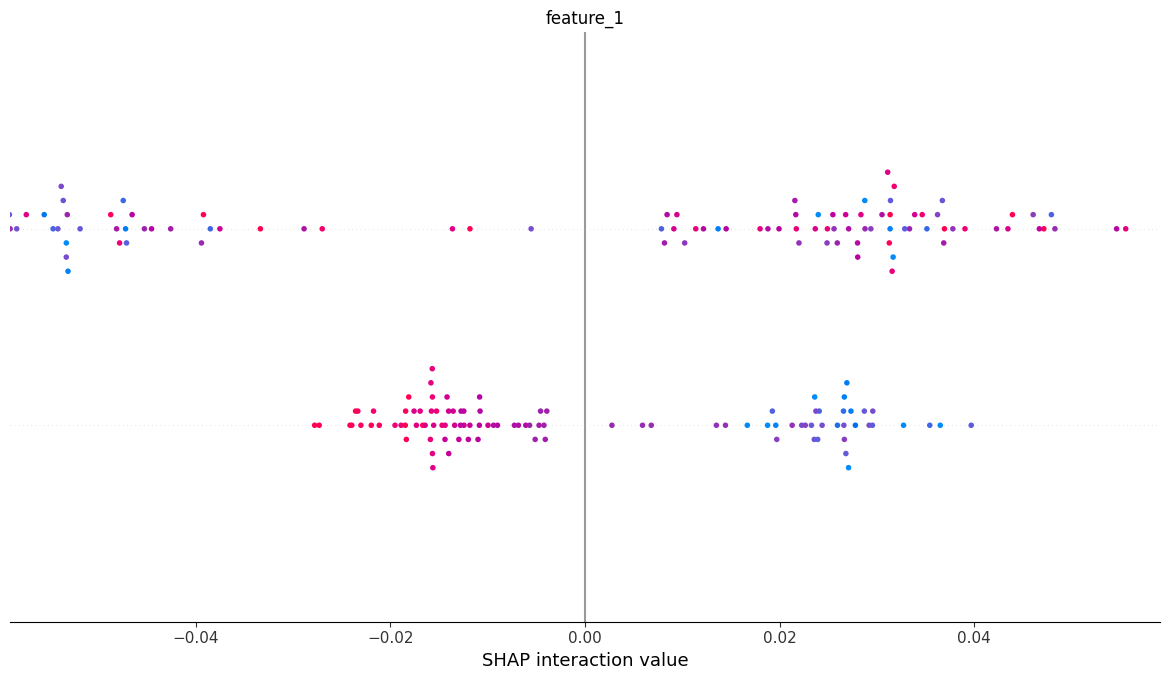

In [29]:
import shap
X_explain = X_test.sample(n=100, random_state=42)

# Initializing SHAP explainer for tree-based model
explainer = shap.Explainer(best_rf, X_explain)
shap_values = explainer(X_explain)

# Plotting the summary bar chart (most important features)
shap.summary_plot(shap_values, X_explain, plot_type="bar")